In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.1017

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 601ms/step - loss: 0.0834
Average validation loss: 0.6474612355232239
4/4 [==============================] - 6s 618ms/step - loss: 0.0834 - val_loss: 0.6475
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 587ms/step - loss: 0.0634 - val_loss: 0.6475
Average validation loss: 0.5906069278717041
4/4 [==============================] - 8s 599ms/step - loss: 0.0634 - val_loss: 0.6190
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 610ms/step - loss: 0.0491 - val_loss: 0.6190
Average validation loss: 0.5584222078323364
4/4 [==============================] - 11s 620ms/step - loss: 0.0491 - val_loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 719ms/step - loss: 0.0027
Average validation loss: 0.0018864480080083013
8/8 [==============================] - 6s 733ms/step - loss: 0.0027 - val_loss: 0.0019
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 714ms/step - loss: 0.0027 - val_loss: 0.0019
Average validation loss: 0.006761050783097744
8/8 [==============================] - 12s 726ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 3/10
8/8 [==============================] - 18s 719ms/step - loss: 0.0026 - val_loss: 0.0043
Average validation loss: 0.08410114049911499
8/8 [==============================] - 18s 733ms/step - loss: 0.0026 - val_loss: 0.0309
Epoch 4/10
8/8 [==============================] - 24s 724ms/step - loss: 0.0025 - val_loss: 0.0309
Average validation loss: 0.0006208395352587104
8/8 [======

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 711ms/step - loss: 0.0030
Average validation loss: 0.07640883823235829
12/12 [==============================] - 9s 723ms/step - loss: 0.0030 - val_loss: 0.0764
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 727ms/step - loss: 0.0030 - val_loss: 0.0764
Average validation loss: 0.04048695849875609
12/12 [==============================] - 18s 741ms/step - loss: 0.0030 - val_loss: 0.0584
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 702ms/step - loss: 0.0030 - val_loss: 0.0584
Average validation loss: 0.027666271353761356
12/12 [==============================] - 26s 715ms/step - los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 727ms/step - loss: 0.0022
Average validation loss: 0.05234679952263832
16/16 [==============================] - 12s 739ms/step - loss: 0.0022 - val_loss: 0.0523
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 736ms/step - loss: 0.0021 - val_loss: 0.0523
Average validation loss: 0.08027135171869304
16/16 [==============================] - 24s 747ms/step - loss: 0.0021 - val_loss: 0.0663
Epoch 3/10
16/16 [==============================] - 35s 723ms/step - loss: 0.0021 - val_loss: 0.0663
Average validation loss: 0.1337579069659114
16/16 [==============================] - 36s 735ms/step - loss: 0.0021 - val_loss: 0.0888
Epoch 4/10
16/16 [==============================] - 47s 717ms/step - loss: 0.0020 - val_loss: 0.0888
Average validation loss: 0.047209151554852724


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 728ms/step - loss: 0.0015
Average validation loss: 0.06418751296587288
20/20 [==============================] - 15s 739ms/step - loss: 0.0015 - val_loss: 0.0642
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 719ms/step - loss: 0.0014 - val_loss: 0.0642
Average validation loss: 0.04176423337776214
20/20 [==============================] - 30s 733ms/step - loss: 0.0014 - val_loss: 0.0530
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 707ms/step - loss: 0.0014 - val_loss: 0.0530
Average validation loss: 0.04966536872088909
20/20 [==============================] - 44s 718ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 712ms/step - loss: 0.0015
Average validation loss: 0.28612400591373444
24/24 [==============================] - 17s 723ms/step - loss: 0.0015 - val_loss: 0.2861
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 712ms/step - loss: 0.0014 - val_loss: 0.2861
Average validation loss: 0.03585475000242392
24/24 [==============================] - 35s 723ms/step - loss: 0.0014 - val_loss: 0.1610
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 711ms/step - loss: 0.0013 - val_loss: 0.1610
Average validation loss: 0.07005781928698222
24/24 [==============================] - 52s 722ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 709ms/step - loss: 0.0024
Average validation loss: 0.0781282614916563
40/40 [==============================] - 29s 721ms/step - loss: 0.0024 - val_loss: 0.0781
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 708ms/step - loss: 0.0021 - val_loss: 0.0781
Average validation loss: 0.06114511340856552
40/40 [==============================] - 58s 720ms/step - loss: 0.0021 - val_loss: 0.0696
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 86s 715ms/step - loss: 0.0020 - val_loss: 0.0696
Average validation loss: 0.05407560728490353
40/40 [==============================] - 87s 727ms/step - los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 714ms/step - loss: 0.0014
Average validation loss: 0.24179708616187176
48/48 [==============================] - 35s 727ms/step - loss: 0.0014 - val_loss: 0.2418
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 713ms/step - loss: 0.0012 - val_loss: 0.2418
Average validation loss: 0.04754374665208161
48/48 [==============================] - 70s 725ms/step - loss: 0.0012 - val_loss: 0.1447
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 105s 722ms/step - loss: 0.0011 - val_loss: 0.1447
Average validation loss: 0.04703213087486802
48/48 [==============================] - 105s 734ms/step - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 735ms/step - loss: 0.0015
Average validation loss: 0.3087314175707953
56/56 [==============================] - 42s 748ms/step - loss: 0.0015 - val_loss: 0.3087
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 715ms/step - loss: 0.0012 - val_loss: 0.3087
Average validation loss: 0.25223917088338305
56/56 [==============================] - 83s 726ms/step - loss: 0.0012 - val_loss: 0.2805
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 123s 721ms/step - loss: 0.0010 - val_loss: 0.2805
Average validation loss: 0.2798434080822127
56/56 [==============================] - 124s 732ms/step - lo

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 718ms/step - loss: 0.0012
Average validation loss: 0.08445392653811723
64/64 [==============================] - 47s 730ms/step - loss: 0.0012 - val_loss: 0.0845
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 719ms/step - loss: 9.3750e-04 - val_loss: 0.0845
Average validation loss: 0.1437946273945272
64/64 [==============================] - 94s 730ms/step - loss: 9.3750e-04 - val_loss: 0.1141
Epoch 3/10
64/64 [==============================] - 140s 721ms/step - loss: 7.9454e-04 - val_loss: 0.1141
Average validation loss: 0.101799292024225
64/64 [==============================] - 140s 732ms/step - loss: 7.9454e-04 - val_loss: 0.1100
Epoch 4/10
64/64 [==============================] - 186s 716ms/step - loss: 7.1097e-04 - val_loss: 0.1100
Average validation loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 714ms/step - loss: 0.0011
Average validation loss: 0.07767065345413154
72/72 [==============================] - 52s 725ms/step - loss: 0.0011 - val_loss: 0.0777
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 715ms/step - loss: 8.8148e-04 - val_loss: 0.0777
Average validation loss: 0.08301116360558404
72/72 [==============================] - 105s 726ms/step - loss: 8.8148e-04 - val_loss: 0.0803
Epoch 3/10
72/72 [==============================] - 156s 720ms/step - loss: 7.9431e-04 - val_loss: 0.0803
Average validation loss: 0.12467214237484667
72/72 [==============================] - 157s 731ms/step - loss: 7.9431e-04 - val_loss: 0.0951
Epoch 4/10
72/72 [==============================] - 209s 714ms/step - loss: 7.1149e-04 - val_loss: 0.0951
Average validation l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 715ms/step - loss: 0.0011
Average validation loss: 0.039547473471611735
80/80 [==============================] - 58s 726ms/step - loss: 0.0011 - val_loss: 0.0395
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 115s 714ms/step - loss: 8.5064e-04 - val_loss: 0.0395
Average validation loss: 0.05112775396555662
80/80 [==============================] - 116s 725ms/step - loss: 8.5064e-04 - val_loss: 0.0453
Epoch 3/10
80/80 [==============================] - 174s 718ms/step - loss: 7.5908e-04 - val_loss: 0.0453
Average validation loss: 0.04111538166180253
80/80 [==============================] - 175s 730ms/step - loss: 7.5908e-04 - val_loss: 0.0439
Epoch 4/10
80/80 [==============================] - 232s 719ms/step - loss: 6.9950e-04 - val_loss: 0.0439
Average validation

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 724ms/step - loss: 0.0015
Average validation loss: 0.22682562159995237
96/96 [==============================] - 71s 735ms/step - loss: 0.0015 - val_loss: 0.2268
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 714ms/step - loss: 0.0011 - val_loss: 0.2268
Average validation loss: 0.14403349937250218
96/96 [==============================] - 140s 725ms/step - loss: 0.0011 - val_loss: 0.1854
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 715ms/step - loss: 9.3488e-04 - val_loss: 0.1854
Average validation loss: 0.031837074706951775
96/96 [==============================] - 210s 726m

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 719ms/step - loss: 0.0010
Average validation loss: 0.049608494217197104
120/120 [==============================] - 88s 731ms/step - loss: 0.0010 - val_loss: 0.0496
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 718ms/step - loss: 8.3961e-04 - val_loss: 0.0496
Average validation loss: 0.03521877688666185
120/120 [==============================] - 175s 729ms/step - loss: 8.3961e-04 - val_loss: 0.0424
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 717ms/step - loss: 8.2683e-04 - val_loss: 0.0424
Average validation loss: 0.0567335377757748
120/120 [========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 715ms/step - loss: 9.5816e-04
Average validation loss: 0.06461478386902147
144/144 [==============================] - 105s 727ms/step - loss: 9.5816e-04 - val_loss: 0.0646
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 721ms/step - loss: 7.7980e-04 - val_loss: 0.0646
Average validation loss: 0.04455962575351199
144/144 [==============================] - 210s 732ms/step - loss: 7.7980e-04 - val_loss: 0.0546
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 314s 718ms/step - loss: 6.7593e-04 - val_loss: 0.0546
Average validation loss: 0.03798000297198693
144/144 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 720ms/step - loss: 7.0511e-04
Average validation loss: 0.0649850545451045
160/160 [==============================] - 117s 732ms/step - loss: 7.0511e-04 - val_loss: 0.0650
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 716ms/step - loss: 5.5241e-04 - val_loss: 0.0650
Average validation loss: 0.05083539839833975
160/160 [==============================] - 234s 727ms/step - loss: 5.5241e-04 - val_loss: 0.0579
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 714ms/step - loss: 5.0041e-04 - val_loss: 0.0579
Average validation loss: 0.03972887352574617
160/160 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 716ms/step - loss: 0.0012
Average validation loss: 0.11428429781459272
200/200 [==============================] - 145s 727ms/step - loss: 0.0012 - val_loss: 0.1143
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 717ms/step - loss: 9.9796e-04 - val_loss: 0.1143
Average validation loss: 0.07250070542097092
200/200 [==============================] - 291s 729ms/step - loss: 9.9796e-04 - val_loss: 0.0934
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 435s 717ms/step - loss: 8.6351e-04 - val_loss: 0.0934
Average validation loss: 0.07208892844617366
200/200 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:47 - loss: 0.0135

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 171s 714ms/step - loss: 7.8874e-04
Average validation loss: 0.04454093343423059
240/240 [==============================] - 174s 725ms/step - loss: 7.8874e-04 - val_loss: 0.0445
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 716ms/step - loss: 6.4421e-04 - val_loss: 0.0445
Average validation loss: 0.05168107547251566
240/240 [==============================] - 349s 727ms/step - loss: 6.4421e-04 - val_loss: 0.0481
Epoch 3/10
240/240 [==============================] - 521s 717ms/step - loss: 5.7165e-04 - val_loss: 0.0481
Average validation loss: 0.04949814588277756
240/240 [==============================] - 524s 729ms/step - loss: 5.7165e-04 - val_loss: 0.0486
Epoch 4/10
240/240 [==============================] - 696s 717ms/step - loss: 5.4193e-04 - val_loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.06724670151212152, 0.05385700307073421, 0.09986336861760643, 0.06710088212887967, 0.04208582701167871, 0.04512886390062098, 0.06785839095164556, 0.0776045730158334, 0.12515121379867195, 0.06086574240231068, 0.055875445742793885, 0.06086821661714929, 0.0685509970226364, 0.04106269575923215, 0.05466110270690276, 0.05073327951766351, 0.053954615596312205, 0.04756463781052517]
std_val_losses =  [0.1544237100215795, 0.04537501454760259, 0.09734265696167044, 0.02780024153084995, 0.017576628701766163, 0.041003624271500776, 0.0483955746703549, 0.04133360726352246, 0.07196652552018842, 0.0251394732117947, 0.026809596516396788, 0.026062695948023705, 0.037105959275179554, 0.01576073293905392, 0.015063352953358118, 0.01636236025647871, 0.020705713804395745, 0.020672870154618633]


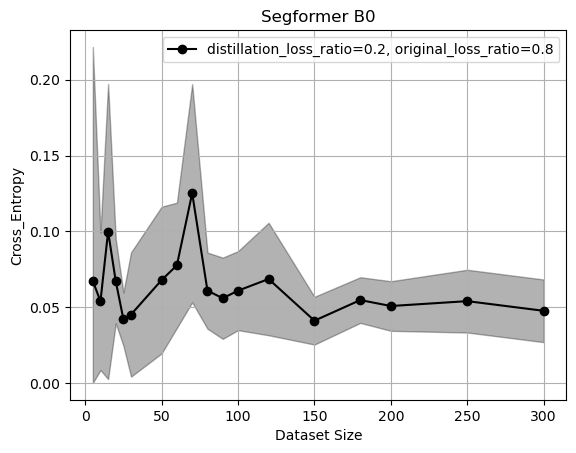

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()